Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нужно построить модель для определения стоимости. 

Важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

### Признаки
#### DateCrawled — дата скачивания анкеты из базы
#### VehicleType — тип автомобильного кузова
#### RegistrationYear — год регистрации автомобиля
#### Gearbox — тип коробки передач
#### Power — мощность (л. с.)
#### Model — модель автомобиля
#### Kilometer — пробег (км)
#### RegistrationMonth — месяц регистрации автомобиля
#### FuelType — тип топлива
#### Brand — марка автомобиля
#### NotRepaired — была машина в ремонте или нет
#### DateCreated — дата создания анкеты
#### NumberOfPictures — количество фотографий автомобиля
#### PostalCode — почтовый индекс владельца анкеты (пользователя)
#### LastSeen — дата последней активности пользователя
### Целевой признак
#### Price — цена (евро)



# 1. Подготовка данных

In [1]:
import pandas as pd

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb


In [8]:
df=pd.read_csv('/datasets/autos.csv')

In [9]:
df.to_csv('autos.csv')

In [4]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


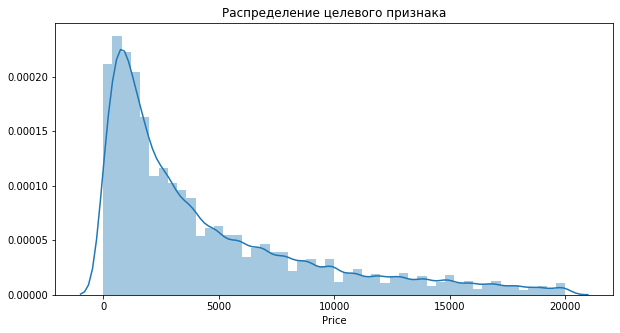

In [6]:
# Распределение целевого признака
plt.figure(figsize=(10,5))
plt.title('Распределение целевого признака')
sns.distplot(df['Price'])

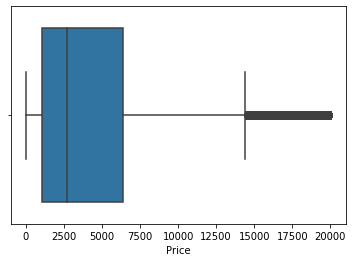

In [7]:
sns.boxplot(df['Price'])

In [8]:
# Удалаяю все наны.
df=df.dropna()

In [9]:
# Удаляю выбросы по цене. Убаляю все что меньше первого квантиля
df=df.loc[(df['Price']>1000) &(df['Price']<20000)]

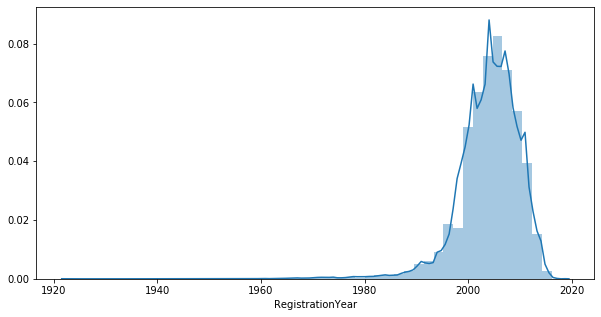

In [10]:
plt.figure(figsize=(10,5))
sns.distplot(df['RegistrationYear'])


In [11]:
# Удаляю выбросы по году регистрации все что < 1980 года
df=df.loc[(df['RegistrationYear']>1980)]

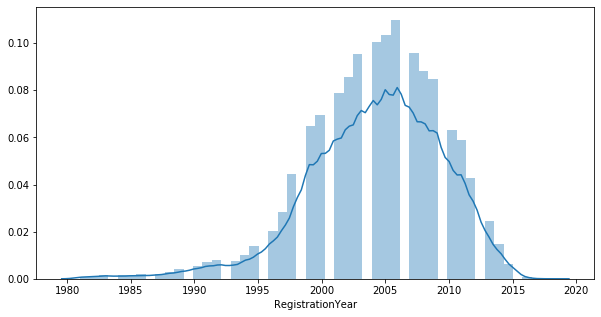

In [12]:
plt.figure(figsize=(10,5))
sns.distplot(df['RegistrationYear'])

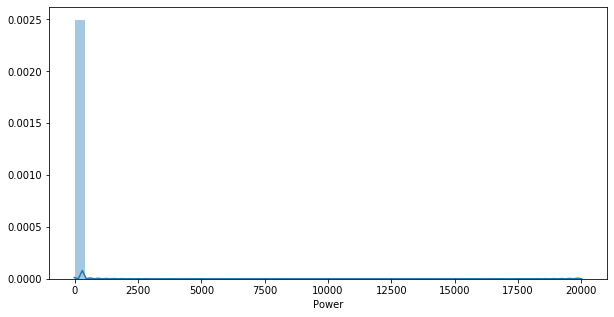

In [13]:
plt.figure(figsize=(10,5))
sns.distplot(df['Power'])

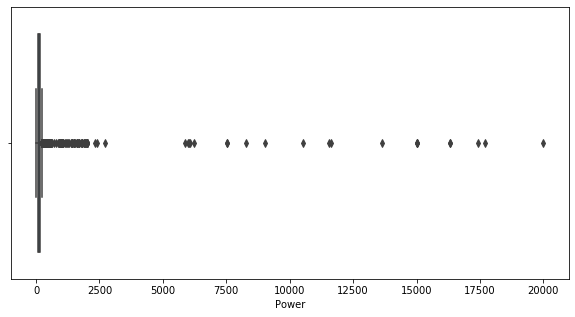

In [14]:
plt.figure(figsize=(10,5))
sns.boxplot(df['Power'])

In [15]:
# Удаляю выбросы по мощности
df=df.loc[(df['Power']>70)&(df['Power']<300)]

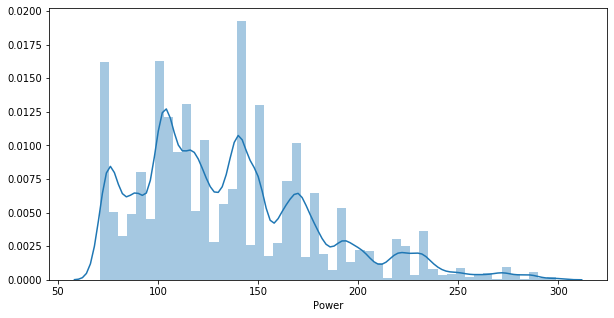

In [16]:
plt.figure(figsize=(10,5))
sns.distplot(df['Power'])

In [17]:
df.isnull().sum()

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
NotRepaired          0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64

In [18]:
#del df['DateCrawled']
#df['DateCrawled']=pd.to_datetime(df['DateCrawled'])

In [46]:
#df['DateCreated']=pd.to_datetime(df['DateCreated'])

In [47]:
#df['LastSeen']=pd.to_datetime(df['LastSeen'])

In [ ]:
#df.head()

In [48]:
#Сколько дней между датой последней активности и датой создания объявления
#df['DateCreated-LastSeen']=df['LastSeen']-df['DateCreated']
#df['DateCreated-LastSeen']=df['DateCreated-LastSeen'].dt.round('1D')

In [49]:
#Сколько дней между датой скачивания и датой создания объявления
#df['DateCrawled-DateCreated']=df['DateCrawled']-df['DateCreated']
#df['DateCrawled-DateCreated']=df['DateCrawled-DateCreated'].dt.round('1D')

In [19]:
#Удаляю столбы
del df['LastSeen']
del df['DateCreated']
del df['DateCrawled']

In [20]:
#Удаляю столбы
del df['RegistrationMonth']
del df['PostalCode']


In [21]:
#Удаляю столбы
del df['NumberOfPictures']

In [22]:
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no
10,2000,sedan,2004,manual,105,3_reihe,150000,petrol,mazda,no
11,2799,wagon,2005,manual,140,passat,150000,gasoline,volkswagen,yes
14,17999,suv,2011,manual,190,navara,70000,gasoline,nissan,no


# 2. Обучение моделей

In [23]:
target=df['Price']
features=df.drop(['Price'],axis=1)

In [24]:
train_features,valid_features,train_target,valid_tagret=train_test_split(features,target,test_size=0.3,random_state=1234)

In [25]:
#Определяю индексы для столбцов не типа int. Те нахожу категориальные столбцы
cat_feat=np.where(features.dtypes!= np.int64)[0]
cat_feat

array([0, 2, 4, 6, 7, 8])

### CatBoostingRegressor

0:	learn: 4326.5744180	total: 852ms	remaining: 28m 23s
100:	learn: 1637.5762923	total: 1m 2s	remaining: 19m 34s
200:	learn: 1547.9508180	total: 2m 4s	remaining: 18m 35s
300:	learn: 1495.9827846	total: 3m 9s	remaining: 17m 52s
400:	learn: 1464.3773120	total: 4m 15s	remaining: 16m 57s
500:	learn: 1434.6135957	total: 5m 21s	remaining: 16m 3s
600:	learn: 1410.4260570	total: 6m 28s	remaining: 15m 5s
700:	learn: 1391.4039935	total: 7m 35s	remaining: 14m 4s
800:	learn: 1375.6028939	total: 8m 43s	remaining: 13m 3s
900:	learn: 1361.0008546	total: 9m 51s	remaining: 12m 1s
1000:	learn: 1348.7702564	total: 10m 58s	remaining: 10m 57s
1100:	learn: 1336.8879809	total: 12m 6s	remaining: 9m 52s
1200:	learn: 1325.9685915	total: 13m 13s	remaining: 8m 47s
1300:	learn: 1314.7550410	total: 14m 19s	remaining: 7m 41s
1400:	learn: 1306.2574077	total: 15m 28s	remaining: 6m 36s
1500:	learn: 1296.6606614	total: 16m 36s	remaining: 5m 31s
1600:	learn: 1288.1855562	total: 17m 42s	remaining: 4m 24s
1700:	learn: 1279.

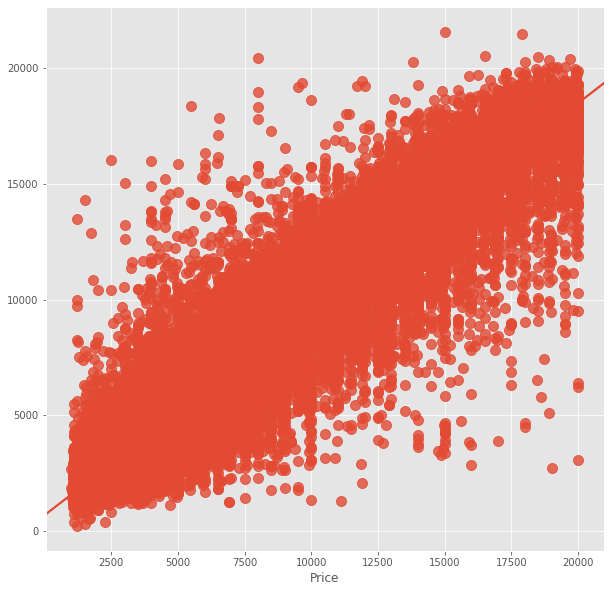

In [26]:
%%time

plt.style.use('ggplot') 
#for i in range(50,500,50):
model_cat=CatBoostRegressor(depth=10,
                        iterations=2000,
                        learning_rate=0.1,
                        loss_function='RMSE').fit(train_features,train_target,cat_features=cat_feat,verbose=100)
predict=model_cat.predict(valid_features)
rmse=mean_squared_error(predict,valid_tagret)
print('RMSE: ',np.sqrt(rmse))
plt.figure( figsize= (10 , 10 )) 
sns.regplot(valid_tagret,  predict,  fit_reg= True,  scatter_kws= {"s":  100 }) 


iterations=700,learning_rate=0.1,
RMSE:  1673.0043916855836
CPU times: user 3min 17s, sys: 30.8 s, total: 3min 48s
Wall time: 3min 54s

iterations=1500,learning_rate=0.1,
RMSE:  1634.5591480390026
CPU times: user 6min 59s, sys: 1min 7s, total: 8min 7s
Wall time: 8min 15s

iterations=2000,learning_rate=0.1
RMSE:  1624.5963775577761
CPU times: user 9min 24s, sys: 1min 31s, total: 10min 56s
Wall time: 11min 2s

iterations=2000,learning_rate=1
RMSE:  1682.6714880877084
CPU times: user 9min 9s, sys: 1min 29s, total: 10min 39s
Wall time: 10min 46s

iterations=2000,learning_rate=0.1,depth=3
RMSE:  1721.7616287957549
CPU times: user 4min 40s, sys: 47.6 s, total: 5min 27s
Wall time: 5min 32s

iterations=2000,learning_rate=0.1,depth=5
RMSE:  1648.8952505979305
CPU times: user 7min 50s, sys: 1min 17s, total: 9min 7s
Wall time: 9min 13s

iterations=2000,learning_rate=0.1,depth=10
RMSE:  1587.0726078921134
CPU times: user 20min 33s, sys: 2min 13s, total: 22min 47s
Wall time: 22min 55s


Text(0.5, 0, 'Importance')

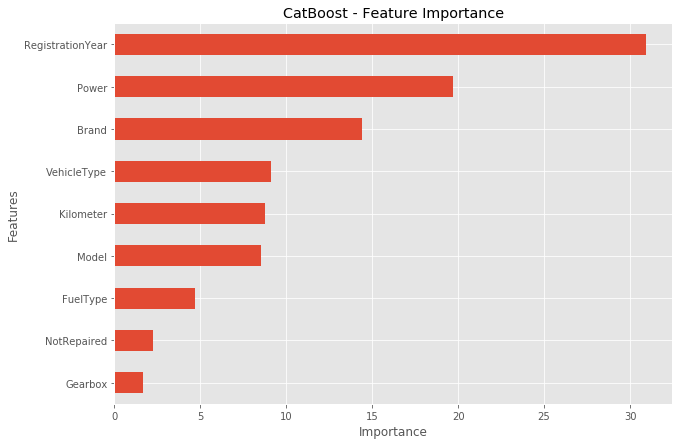

In [27]:
fea_imp = pd.DataFrame({'imp': model_cat.feature_importances_, 'col': train_features.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-10:]
fea_imp.plot(kind='barh', x='col', y='imp', figsize=(10, 7), legend=None)
plt.title('CatBoost - Feature Importance')
plt.ylabel('Features')
plt.xlabel('Importance')

In [ ]:
#Ищу лучшие параметры

model = CatBoostRegressor()
parameters = {'depth'         : [2,8,10],
                 'learning_rate' : [0.1,0.5],
                 'iterations'    : [400,700]
                }
grid = GridSearchCV(estimator=model, param_grid = parameters, cv = 2, n_jobs=-1)
grid.fit(train_features,train_target,cat_features=cat_feat,verbose=100)    

    # Results from Grid Search
print("\n========================================================")
print(" Результаты Grid Search " )
print("========================================================")    
    
print("\n The best estimator across ALL searched params:\n",
          grid.best_estimator_)
    
print("\n The best score across ALL searched params:\n",
          grid.best_score_)
    
print("\n The best parameters across ALL searched params:\n",
          grid.best_params_)
    
print("\n ========================================================")

0:	learn: 4446.4678553	total: 58ms	remaining: 23.1s
100:	learn: 2069.1691652	total: 6.49s	remaining: 19.2s
200:	learn: 1989.8859065	total: 12.6s	remaining: 12.5s
300:	learn: 1937.4402677	total: 18.5s	remaining: 6.09s
399:	learn: 1902.6230067	total: 24.3s	remaining: 0us
0:	learn: 4442.6859961	total: 15.4ms	remaining: 6.15s
100:	learn: 2041.1307406	total: 6.45s	remaining: 19.1s
200:	learn: 1965.1474573	total: 12.3s	remaining: 12.2s
300:	learn: 1908.4534111	total: 18s	remaining: 5.93s
399:	learn: 1878.1113441	total: 23.8s	remaining: 0us
0:	learn: 3666.4082332	total: 71.3ms	remaining: 28.4s


### lightgbm regressor

#### Ohe

In [29]:
# Нахожу категориальные признаки
cat_features_index=np.where(features.dtypes==np.object)
cat_features_index

(array([0, 2, 4, 6, 7, 8]),)

In [30]:
categorical_features=features.columns.get_values()[cat_features_index]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  """Entry point for launching an IPython kernel.


In [31]:
categorical_features

array(['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand',
       'NotRepaired'], dtype=object)

In [32]:
# Произвожу перевод категориальные признаки с помощью OHE
features_lbm=pd.get_dummies(features,columns=categorical_features,drop_first=True)

<span style="color:purple">Возможно я ошибаюсь, но у LGBM тоже есть режим, когда он работает с категориальными признаками. Не так мощно, как CatBoost, но все же. Туда кажется надо только чиселки подать, и будет работать. Не пробовал? Т.е. не обязательно делать OHE.</span>

In [33]:
train_features_lbm,valid_features_lbm,train_target_lbm,valid_tagret_lbm=train_test_split(features_lbm,target,test_size=0.3,random_state=1234)

In [42]:
# Параметры для обучающей модели
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'max_depth': 5, 
    'learning_rate': 1,
    'verbose': 0,
    'early_stopping_round': 20}
n_estimators = 2000

In [43]:
%%time
d_train = lgb.Dataset(train_features_lbm, label=train_target_lbm)
d_valid = lgb.Dataset(valid_features_lbm, label=valid_tagret_lbm)
watchlist = [d_valid]

model = lgb.train(params, d_train, n_estimators, watchlist, verbose_eval=1)

preds = model.predict(valid_features_lbm)

rmse=mean_squared_error(preds,valid_tagret)
print('RMSE: ',np.sqrt(rmse))

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 2506.26
Training until validation scores don't improve for 20 rounds
[2]	valid_0's rmse: 2302.28
[3]	valid_0's rmse: 2172.7
[4]	valid_0's rmse: 2123.42
[5]	valid_0's rmse: 2095.34
[6]	valid_0's rmse: 2058.41
[7]	valid_0's rmse: 2045.66
[8]	valid_0's rmse: 2012.43
[9]	valid_0's rmse: 2001.54
[10]	valid_0's rmse: 1993.54
[11]	valid_0's rmse: 1984.91
[12]	valid_0's rmse: 1974.46
[13]	valid_0's rmse: 1969.57
[14]	valid_0's rmse: 1962.68
[15]	valid_0's rmse: 1947.68
[16]	valid_0's rmse: 1928.52
[17]	valid_0's rmse: 1924.58
[18]	valid_0's rmse: 1918.49
[19]	valid_0's rmse: 1914.61
[20]	valid_0's rmse: 1912.61
[21]	valid_0's rmse: 1909.34
[22]	valid_0's rmse: 1885.49
[23]	valid_0's rmse: 1874.32
[24]	valid_0's rmse: 1872.62
[25]	valid_0's rmse: 1869.28
[26]	valid_0's rmse: 1859.18
[27]	valid_0's rmse: 1853.63
[28]	valid_0's rmse: 1849.81
[29]	valid_0's rmse: 1841.92
[30]	valid_0's rmse: 1840.71
[31]	valid_0's rmse: 1838.21
[32]	valid_0's rmse: 1826.71
[33]	valid_0's rmse: 

Рзные опыты для модели:
'max_depth': 10, 'learning_rate': 0.1,n_estimators = 2000
RMSE:  1589.8703657922135
CPU times: user 2min 12s, sys: 0 ns, total: 2min 12s
Wall time: 2min 15s

'max_depth': 10, 'learning_rate': 1,n_estimators = 2000
RMSE:  1589.8703657922129
CPU times: user 1min 59s, sys: 0 ns, total: 1min 59s
Wall time: 2min 1s

'max_depth': 5, 'learning_rate': 1,n_estimators = 2000
RMSE:  1670.7863548119585
CPU times: user 52.3 s, sys: 0 ns, total: 52.3 s
Wall time: 53.2 s

#### Строю соотношение предсказаний и target

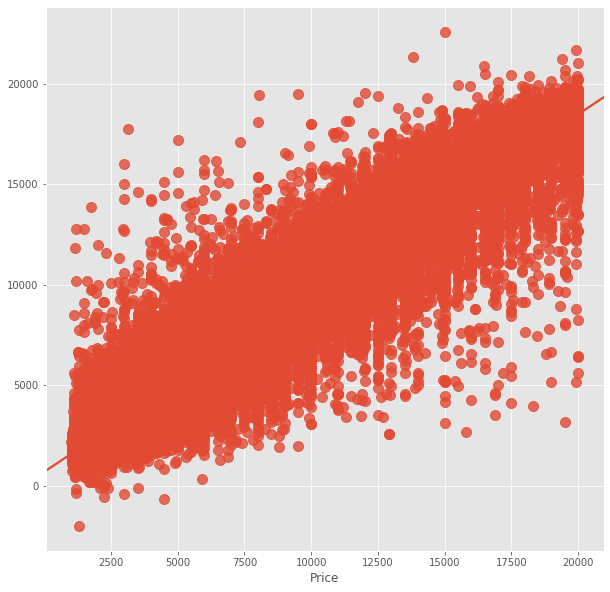

In [36]:
plt.figure( figsize= (10 , 10 )) 
sns.regplot(valid_tagret_lbm,  preds,  fit_reg= True,  scatter_kws= {"s":  100 }) 

# 3. Анализ моделей

Анализируя модель lightgbm regressor можно сделать вывод, что лучшими параметрами оказались 'max_depth': 10, 'learning_rate': 1,n_estimators = 2000
RMSE:  1589.8703657922129
total: 1min 59s
Перебирая разные значения max_depth- сильно меняется качество предсказания. При уменьшении его в половину почти в половину уменьшается время, но при этом сильно падает качество. При изменении learning_rate, качество приедсказания не меняется но меняется время, поэтому этот папаметр я выбрал грубым, что время уменьшить.

Если сравнивать с моделью Catboosting, то похожий лучший результат я получил при параметрах для CatBoosting:
iterations=2000,learning_rate=0.1,depth=10
RMSE:  1587.0726078921134
CPU times: user 20min 33s, sys: 2min 13s, total: 22min 47s
22 минуты  от CatBoosting против 2 мин от lightgbm.

